In [1]:
import numpy as np, imp, os, datetime as dt, pandas as pd, matplotlib.pyplot as plt

# Path to folder containing wrapper modules
wrapper_fpath = (r"..\inca.py")
optimize_funs_fpath = (r'..\inca_calibration.py')

wr = imp.load_source('inca',wrapper_fpath)
cf = imp.load_source('inca_calibration', optimize_funs_fpath)

### Set up

In [2]:
wr.initialize('simplyc.dll')
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyC/SimplyC_params_noGW.dat',
                                                            '../../Applications/SimplyC/langtjerninputs.dat')

### Take a look at what is contained in the dataset

In [3]:
print ('Index sets: %s' %dataset.get_index_sets())
print ('Indices in 1st index set: %s' %dataset.get_indexes(dataset.get_index_sets()[0]))
print ('Indices in 2nd index set: %s' %dataset.get_indexes(dataset.get_index_sets()[1]))

Index sets: ['Reaches', 'Landscape units']
Indices in 1st index set: ['Inlet']
Indices in 2nd index set: ['Forest and bog']


In [4]:
air_temp = dataset.get_input_series('Air temperature',[])
air_temp

array([-17.21   , -12.24   , -12.34   , ...,  -5.78806,  -1.18806,
        -1.08806])

In [5]:
dataset.get_parameter_list()

[('Timesteps', 'uint'),
 ('Start date', 'time'),
 ('Latitude', 'double'),
 ('Initial snow depth as water equivalent', 'double'),
 ('Degree-day factor for snowmelt', 'double'),
 ('Proportion of precipitation that contributes to quick flow', 'double'),
 ('PET reduction factor', 'double'),
 ('Soil field capacity', 'double'),
 ('Gradient of stream velocity-discharge relationship', 'double'),
 ('Exponent of stream velocity-discharge relationship', 'double'),
 ('Catchment area', 'double'),
 ('Reach length', 'double'),
 ('Initial in-stream flow', 'double'),
 ('Soil water time constant', 'double'),
 ('Land use proportions', 'double'),
 ('Snow depth / soil temperature factor', 'double'),
 ('Initial soil temperature', 'double'),
 ('Soil thermal conductivity (W/m/°C, range 0.4-0.8) divided by soil specific heat capacity (MJ/m3/°C, range 1.0-1.3; more like 4-15 if there is freeze-thaw)',
  'double'),
 ('Gradient of the soil water [DOC] response to changing soil temperature',
  'double'),
 ('Coeffi

### Run the model to see what the results look like with manually-calibrated parameters

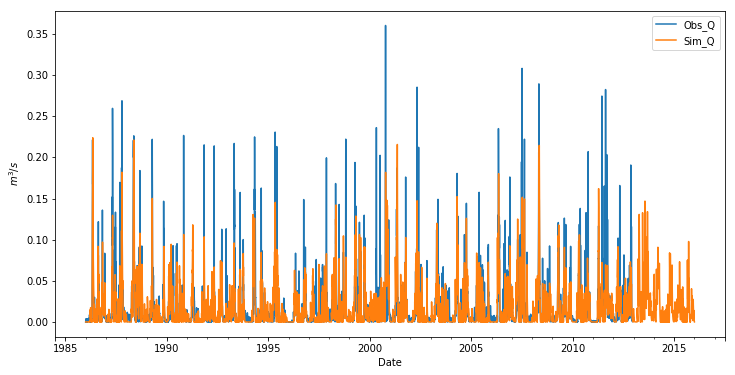

In [6]:
dataset.run_model()

# Read data from the dataset
simQ = dataset.get_result_series('Reach flow (daily mean, cumecs)', ['Inlet'])
obsQ = dataset.get_input_series('Discharge', [], alignwithresults=True)
start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
timesteps = dataset.get_parameter_uint('Timesteps', [])
unit = dataset.get_result_unit('Reach flow (daily mean, cumecs)')

# Use data to make a pandas dataframe
date_idx = np.array(pd.date_range(start_date, periods=timesteps))
df = pd.DataFrame({'Date':date_idx, 'Obs_Q': obsQ, 'Sim_Q': simQ})
df.set_index('Date', inplace=True)

# Plot
fig, ax = plt.subplots()
df.plot(figsize=(12,6), ax=ax)
ax.set_ylabel('$%s$' % unit)
plt.show()

In [7]:
objective = (0, 'Reach flow (daily mean, cumecs)', ['Inlet'], 'Discharge', [], 0)
cf.print_goodness_of_fit(dataset, objective)


Goodness of fit for Reach flow (daily mean, cumecs) [Inlet] vs Discharge []:
Mean error (bias): -0.000486
Mean absolute error: 0.010909
Mean square error: 0.000450
Nash-Sutcliffe coefficient: 0.510246



### Set up for optimization

Pick out the parameters we want to calibrate, and set initial values for them as well as minimum and maximum limits we want the algorithm to search within.

In [8]:
#NOTE: The 'calibration' structure is a list of (indexed) parameters that we want to calibrate
calibration = [
    ('Degree-day factor for snowmelt',                             []),
    ('Proportion of precipitation that contributes to quick flow', []),
    ('PET reduction factor',                                       []),
    ('Soil field capacity',                                       []),
    ('Gradient of stream velocity-discharge relationship',         []),
    ('Exponent of stream velocity-discharge relationship',         []),
    ('Soil water time constant',                                   ['Forest and bog']),
    ('Soil field capacity',                                        []),
    ]

# Read the initial guess provided by the parameter file
initial_guess = cf.default_initial_guess(dataset, calibration)
initial_guess.append(0.5) # Variance of residual error term, also to be optimized

# Set upper and lower limits for parameter values
param_min = [0.1 * x for x in initial_guess]
param_max = [10.0 * x for x in initial_guess]

cf.constrain_min_max(dataset, calibration, param_min, param_max) # NOTE: Constrain to the min and max values recommended
                                                              # by the model in case we made our bounds too wide.

skiptimesteps = 30   # Skip these many of the first timesteps in the objective evaluation

objective = (cf.log_likelyhood, 'Reach flow (daily mean, cumecs)', ['Inlet'], 'Discharge', [], skiptimesteps)

In [10]:
param_min

[0.31000000000000005,
 0.010000000000000002,
 0.05500000000000001,
 10.0,
 0.09800000000000002,
 0.1,
 0.6000000000000001,
 10.0,
 0.05]

### Run the optimizer and print the results

In [ ]:
param_est = cf.run_optimization(dataset, param_min, param_max, initial_guess, calibration, objective, minimize=False)
#param_est = param_est[0]

In [ ]:
for idx, cal in enumerate(calibration) :
    name, indexes = cal
    print('Estimated %-60s %-20s %5.2f (range [%5.2f, %5.2f])' %  (name, ', '.join(indexes),
                                                                   param_est[idx],
                                                                   param_min[idx], param_max[idx]))
if len(param_est) > len(calibration) :
    print('M: %f' % param_est[len(calibration)])

### Save the optimized parameter values

Write the optimal values back to the dataset, and then generate a new parameter file that has these values

In [ ]:
set_values(dataset, param_est, calibration)
dataset.write_parameters_to_file('optimal_parameters.dat')

### Run with optimal parameters and plot

Run the model one more time with the optimal parameters and plot simulated output. Save figure to file, and optionally display it here too.

In [ ]:
dataset.run_model()
fig, ax = plot_objective(dataset, objective, "simplyc_plots\\optimizer_MAP.png", return_fig=True)
plt.show()

In [ ]:
objective = (0, 'Reach flow (daily mean, mm/day)', ['Tarland1'], 'observed Q mm/d', [], 0)
print_goodness_of_fit(dataset, objective)

In [ ]:
dataset.delete()